<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Thu Aug  8 09:39:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8              17W / 115W |   2906MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.3.0


device(type='cuda')

## 1. What are 3 areas in industry where computer vision is currently being used?

* Classification
* Object detection
* Segmentation

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting is an undesirable machine learning behavior that occurs when the machine learning model gives accurate predictions for training data but not for new data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

* Regularization
* Cross validation
* Early stopping

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

![CNN Explainer](img/cnn_explainer.png)

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [3]:
import torchvision
from torchvision.transforms.functional import pil_to_tensor

data_root = "./data"
train_ds = torchvision.datasets.MNIST(root=data_root, train=True, transform=pil_to_tensor, download=True)
test_ds = torchvision.datasets.MNIST(root=data_root, train=False, transform=pil_to_tensor, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



In [ ]:
from collections import Counter

label_counter = Counter((x.item() for x in train_ds.targets))
label_counter

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [ ]:
sample_tensor, _ = train_ds[0]
sample_tensor.shape

torch.Size([1, 28, 28])

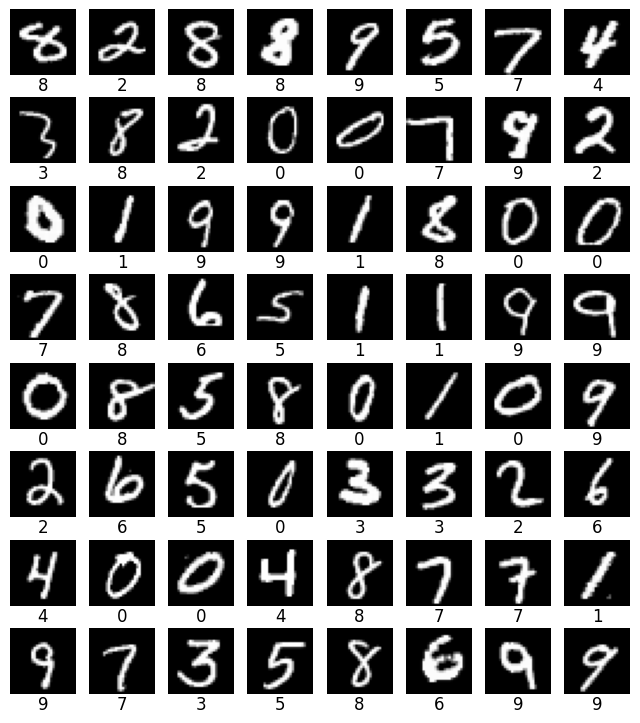

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 9))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label, y=-0.35)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, img_channels: int, img_height: int, img_width: int, num_classes: int, hidden_units: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*(img_height//2//2)*(img_width//2//2), out_features=num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
img_channels, img_height, img_width = sample_tensor.shape
num_classes = len(label_counter) # type: ignore
model_2 = TinyVGG(img_channels, img_height, img_width, num_classes, hidden_units=10)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [ ]:
def train_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

In [ ]:
def test_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    accuracy_fn.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")

In [ ]:
from torchmetrics import Accuracy

# Setup loss and optimizer
optimizer = torch.optim.AdamW(params=model_2.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=num_classes)

In [ ]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from tqdm.auto import tqdm

epochs = 5
cpu_device = torch.device("cpu")
gpu_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
cpu_start_time = timer() # type: ignore
for epoch in tqdm(range(1, epochs+1)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model_2, train_dataloader, optimizer, loss_fn, acc_fn, cpu_device)
    test_step(model_2, test_dataloader, loss_fn, acc_fn, cpu_device)
cpu_end_time = timer() # type: ignore
print_train_time(cpu_start_time, cpu_end_time, cpu_device) # type: ignore

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 1
---------


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?